In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import re
import math
import datetime
import random
import copy
from tqdm import tqdm

from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
#import train and test datasets
train1 = pd.read_csv('/home/felix/Downloads/zimnat/Train.csv', parse_dates = ['join_date'])
test1 = pd.read_csv('/home/felix/Downloads/zimnat/Test.csv', parse_dates=['join_date'])
submission = pd.read_csv('/home/felix/Downloads/zimnat/SampleSubmission.csv')

In [3]:
train1.head()

,ID,join_date,sex,marital_status,birth_year,branch_code,occupation_code,occupation_category_code,P5DA,RIBP,8NN1,7POT,66FJ,GYSR,SOP4,RVSZ,PYUQ,LJR9,N2MW,AHXO,BSTQ,FM3X,K6QO,QBOL,JWFN,JZ9D,J9JW,GHYX,ECY3
0,4WKQSBB,2019-01-02,F,M,1987,1X1H,2A7I,T4MS,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
1,CP5S02H,2019-01-06,F,M,1981,UAOD,2A7I,T4MS,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
2,2YKDILJ,2013-01-06,M,U,1991,748L,QZYX,90QI,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1
3,2S9E81J,2019-01-08,M,M,1990,1X1H,BP09,56SI,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
4,BHDYVFT,2019-01-08,M,M,1990,748L,NO3L,T4MS,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0


In [4]:
test1.head()

,ID,join_date,sex,marital_status,birth_year,branch_code,occupation_code,occupation_category_code,P5DA,RIBP,8NN1,7POT,66FJ,GYSR,SOP4,RVSZ,PYUQ,LJR9,N2MW,AHXO,BSTQ,FM3X,K6QO,QBOL,JWFN,JZ9D,J9JW,GHYX,ECY3
0,F86J5PC,2018-01-12,M,M,1984,94KC,DZRV,90QI,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,H6141K3,2019-01-10,M,M,1996,1X1H,J9SY,90QI,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
2,RBAYUXZ,2020-01-01,F,W,1968,UAOD,2A7I,T4MS,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
3,KCBILBQ,2019-01-02,M,M,1989,94KC,2A7I,T4MS,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,LSEC1ZJ,2020-01-02,F,M,1982,UAOD,0KID,T4MS,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [5]:
# Split features and labels
train1_labels = train1[['P5DA', 'RIBP', '8NN1', '7POT', '66FJ', 'GYSR', 'SOP4', 'RVSZ', 'PYUQ', 'LJR9', 'N2MW', 'AHXO', 'BSTQ', 'FM3X', 'K6QO', 'QBOL', 'JWFN', 'JZ9D', 'J9JW', 'GHYX', 'ECY3']].reset_index(drop=True)
train1_features = train1.drop(columns=['P5DA', 'RIBP', '8NN1', '7POT', '66FJ', 'GYSR', 'SOP4', 'RVSZ', 'PYUQ', 'LJR9', 'N2MW', 'AHXO', 'BSTQ', 'FM3X', 'K6QO', 'QBOL', 'JWFN', 'JZ9D', 'J9JW', 'GHYX', 'ECY3'], axis=1)
test1_features = test1.drop(columns=['P5DA', 'RIBP', '8NN1', '7POT', '66FJ', 'GYSR', 'SOP4', 'RVSZ', 'PYUQ', 'LJR9', 'N2MW', 'AHXO', 'BSTQ', 'FM3X', 'K6QO', 'QBOL', 'JWFN', 'JZ9D', 'J9JW', 'GHYX', 'ECY3'], axis=1)
test1_labels = test1[['P5DA', 'RIBP', '8NN1', '7POT', '66FJ', 'GYSR', 'SOP4', 'RVSZ', 'PYUQ', 'LJR9', 'N2MW', 'AHXO', 'BSTQ', 'FM3X', 'K6QO', 'QBOL', 'JWFN', 'JZ9D', 'J9JW', 'GHYX', 'ECY3']].reset_index(drop=True)

# Combine train and test features in order to apply the feature transformation pipeline to the entire dataset
all_features = pd.concat([train1_features, test1_features]).reset_index(drop=True)
print(all_features.shape, train1_labels.shape)

(39132, 8) (29132, 21)


In [6]:
# determine the threshold for missing values
def percent_missing(df):
    data = pd.DataFrame(df)
    df_cols = list(pd.DataFrame(data))
    dict_x = {}
    for i in range(0, len(df_cols)):
        dict_x.update({df_cols[i]: round(data[df_cols[i]].isnull().mean()*100,2)})
    
    return dict_x

missing = percent_missing(all_features)
df_miss = sorted(missing.items(), key=lambda x: x[1], reverse=True)
print('Percent of missing data')
df_miss[0:9]

Percent of missing data


[('join_date', 0.01),
 ('ID', 0.0),
 ('sex', 0.0),
 ('marital_status', 0.0),
 ('birth_year', 0.0),
 ('branch_code', 0.0),
 ('occupation_code', 0.0),
 ('occupation_category_code', 0.0)]

In [7]:
def handl_miss(df):
    df['join_date'] = df.groupby('branch_code')['join_date'].transform(lambda x: x.fillna(x.mode()[0]))
    return df


all_features = handl_miss(all_features)    

In [8]:
# Let's make sure we handled all the missing values
missing = percent_missing(all_features)
df_miss = sorted(missing.items(), key=lambda x: x[1], reverse=True)
print('Percent of missing data')
df_miss[0:10]

Percent of missing data


[('ID', 0.0),
 ('join_date', 0.0),
 ('sex', 0.0),
 ('marital_status', 0.0),
 ('birth_year', 0.0),
 ('branch_code', 0.0),
 ('occupation_code', 0.0),
 ('occupation_category_code', 0.0)]

In [9]:
all_features['age'] = 2020 - all_features['birth_year']
all_features['join_year'] = all_features['join_date'].dt.year
all_features['join_month'] = all_features['join_date'].dt.month
all_features['join_day'] = all_features['join_date'].dt.day

dt = pd.datetime.now().replace(hour=0, minute=0, second=0, microsecond=0)
all_features['time_period'] = dt - all_features['join_date']

all_features['ageWJ'] = all_features['join_date'].dt.year - all_features['birth_year']
all_features['year_num'] = 2020 - all_features['join_year']

all_features['time_period'] = all_features['time_period'].astype(str)
all_features['time_period'] = all_features['time_period'].str.extract('(\d+)').astype(int)
all_features['yr_0'] = all_features['time_period'] / 365

In [10]:
def logs(res, ls):
    m =res.shape[1]
    for l in ls:
        res = res.assign(newcol = pd.Series(np.log(1.01+res[l])).values)
        res.columns.values[m] = l + '_log'
        m += 1
    return res

log_features = ['birth_year', 'age', 'ageWJ']

all_features = logs(all_features, log_features)

In [11]:
def squares(res, ls):
    m = res.shape[1]
    for l in ls:
        res = res.assign(newcol=pd.Series(res[l]*res[l]).values)
        res.columns.values[m] = l + '_sq'
        m += 1
    return res

squared_features = ['birth_year', 'age', 'ageWJ']
all_features = squares(all_features, squared_features)

In [12]:
all_features = all_features.loc[:, ~all_features.columns.duplicated()]

In [13]:
# Fetch all numeric features
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric = []
for i in all_features.columns:
    if all_features[i].dtype in numeric_dtypes:
        numeric.append(i)

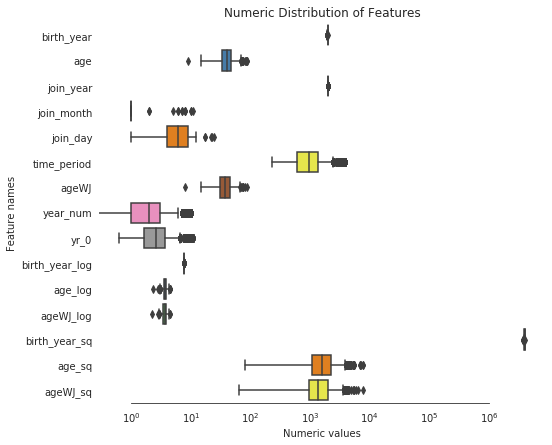

In [14]:
# Create box plots for all numeric features
sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale("log")
ax = sns.boxplot(data=all_features[numeric] , orient="h", palette="Set1")
ax.xaxis.grid(False)
ax.set(ylabel="Feature names")
ax.set(xlabel="Numeric values")
ax.set(title="Numeric Distribution of Features")
sns.despine(trim=True, left=True)

In [15]:
# Find skewed numerical features
skew_features = all_features[numeric].apply(lambda x: x.skew()).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

print("There are {} numerical features with Skew > 0.5 :".format(high_skew.shape[0]))
skewness = pd.DataFrame({'Skew' :high_skew})
skew_features.head(20)

There are 6 numerical features with Skew > 0.5 :


join_month        65.106593
yr_0               1.500776
time_period        1.500776
year_num           1.496821
age_sq             0.744270
ageWJ_sq           0.734483
ageWJ              0.247440
age                0.246128
join_day           0.166672
birth_year_sq     -0.235857
ageWJ_log         -0.244608
birth_year        -0.246128
age_log           -0.253791
birth_year_log    -0.256419
join_year         -1.496821
dtype: float64

In [16]:
# Normalize skewed features
for i in skew_index:
    all_features[i] = boxcox1p(all_features[i], boxcox_normmax(all_features[i] + 1))

In [17]:
X_train__ = all_features.iloc[:len(train1_labels), :]
X_test__ = all_features.iloc[len(train1_labels):, :]
X_train__.shape, train1_labels.shape, X_test__.shape, test1_labels.shape

((29132, 22), (29132, 21), (10000, 22), (10000, 21))

In [18]:
train = pd.concat([X_train__, train1_labels], axis=1)

In [19]:
X_test__ = X_test__.reset_index(drop=True)
test = pd.concat([X_test__, test1_labels], axis=1)

In [20]:
train.head()

,ID,join_date,sex,marital_status,birth_year,branch_code,occupation_code,occupation_category_code,age,join_year,join_month,join_day,time_period,ageWJ,year_num,yr_0,birth_year_log,age_log,ageWJ_log,birth_year_sq,age_sq,ageWJ_sq,P5DA,RIBP,8NN1,7POT,66FJ,GYSR,SOP4,RVSZ,PYUQ,LJR9,N2MW,AHXO,BSTQ,FM3X,K6QO,QBOL,JWFN,JZ9D,J9JW,GHYX,ECY3
0,4WKQSBB,2019-01-02,F,M,1987,1X1H,2A7I,T4MS,33,2019,0.152703,2,13.777227,32,0.716661,0.915514,7.594889,3.526655,3.496811,3948169,17.993312,17.108779,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
1,CP5S02H,2019-01-06,F,M,1981,UAOD,2A7I,T4MS,39,2019,0.152703,6,13.750919,38,0.716661,0.911869,7.591867,3.689129,3.663818,3924361,19.828467,18.875782,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
2,2YKDILJ,2013-01-06,M,U,1991,748L,QZYX,90QI,29,2013,0.152703,6,20.958509,22,2.300857,1.878554,7.596899,3.401531,3.135929,3964081,16.670900,13.710478,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1
3,2S9E81J,2019-01-08,M,M,1990,1X1H,BP09,56SI,30,2019,0.152703,8,13.737714,29,0.716661,0.910041,7.596397,3.434310,3.401531,3960100,17.010007,16.158098,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
4,BHDYVFT,2019-01-08,M,M,1990,748L,NO3L,T4MS,30,2019,0.152703,8,13.737714,29,0.716661,0.910041,7.596397,3.434310,3.401531,3960100,17.010007,16.158098,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0


In [21]:
test.head()

,ID,join_date,sex,marital_status,birth_year,branch_code,occupation_code,occupation_category_code,age,join_year,join_month,join_day,time_period,ageWJ,year_num,yr_0,birth_year_log,age_log,ageWJ_log,birth_year_sq,age_sq,ageWJ_sq,P5DA,RIBP,8NN1,7POT,66FJ,GYSR,SOP4,RVSZ,PYUQ,LJR9,N2MW,AHXO,BSTQ,FM3X,K6QO,QBOL,JWFN,JZ9D,J9JW,GHYX,ECY3
0,F86J5PC,2018-01-12,M,M,1984,94KC,DZRV,90QI,36,2018,0.152703,12,15.703120,34,1.158462,1.184857,7.593379,3.611188,3.555634,3936256,18.930908,17.716170,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,H6141K3,2019-01-10,M,M,1996,1X1H,J9SY,90QI,24,2019,0.152703,10,13.724473,23,0.716661,0.908208,7.599406,3.219276,3.178470,3984016,14.875667,14.083468,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
2,RBAYUXZ,2020-01-01,F,W,1968,UAOD,2A7I,T4MS,52,2020,0.152703,1,10.460394,52,0.000000,0.487397,7.585286,3.970481,3.970481,3873024,23.352495,22.485918,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
3,KCBILBQ,2019-01-02,M,M,1989,94KC,2A7I,T4MS,31,2019,0.152703,2,13.777227,30,0.716661,0.915514,7.595895,3.466048,3.434310,3956121,17.343259,16.480624,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,LSEC1ZJ,2020-01-02,F,M,1982,UAOD,0KID,T4MS,38,2020,0.152703,2,10.446834,38,0.000000,0.485845,7.592371,3.663818,3.663818,3928324,19.533426,18.875782,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [22]:
#print all dataset shape
print(train.shape, test.shape,submission.shape)

(29132, 43) (10000, 43) (210000, 2)


In [26]:
X_train = []
X_train_columns = train.columns
c = 0
for v in train.values:
    info = v[:23]
    binary = v[23:]
    index = [k for k, i in enumerate(binary) if i == 1]
    for i in index:
        c += 1
        for k in range(len(binary)):
            if k == i:
                binary_transformed = list(copy.copy(binary))
                binary_transformed[i] = 0
                X_train.append(list(info) + binary_transformed + [X_train_columns[23+k]] + [c])
                

                
X_train = pd.DataFrame(X_train)
X_train.columns = ['ID', 'join_date', 'sex', 'marital_status', 'birth_year', 'branch_code', 'occupation_code', 'occupation_category_code', 'age', 'join_year', 'join_month', 'join_day', 'time_period', 'ageWJ', 'year_num', 'yr_0', 'birth_year_log', 'age_log', 'ageWJ_log', 'birth_year_sq', 'age_sq', 'ageWJ_sq', 'P5DA', 'RIBP', '8NN1', '7TPOT', '66FJ', 'GYSR', 'SOP4', 'RVSZ', 'PYUQ', 'LJR9', 'N2MW', 'AHXO', 'BSTQ', 'FM3X', 'K6QO', 'QBOL', 'JWFN', 'JZ9D', 'J9JW', 'GHYX', 'ECY3', 'prev_product', 'ID2']

In [28]:
X_test = []
X_test_columns = test.columns
c = 0
for v in test.values:
    info = v[:23]
    binary = v[23:]
    index = [k for k, i in enumerate(binary) if i == 1]
    for i in index:
        c += 1
        for k in range(len(binary)):
            if k == i:
                binary_transformed = list(copy.copy(binary))
                binary_transformed[i] = 0
                X_test.append(list(info) + binary_transformed + [X_test_columns[23+k]] + [c])
                

                
X_test = pd.DataFrame(X_test)
X_test.columns = ['ID', 'join_date', 'sex', 'marital_status', 'birth_year', 'branch_code', 'occupation_code', 'occupation_category_code', 'age', 'join_year', 'join_month', 'join_day', 'time_period', 'ageWJ', 'year_num', 'yr_0', 'birth_year_log', 'age_log', 'ageWJ_log', 'birth_year_sq', 'age_sq', 'ageWJ_sq', 'P5DA', 'RIBP', '8NN1', '7TPOT', '66FJ', 'GYSR', 'SOP4', 'RVSZ', 'PYUQ', 'LJR9', 'N2MW', 'AHXO', 'BSTQ', 'FM3X', 'K6QO', 'QBOL', 'JWFN', 'JZ9D', 'J9JW', 'GHYX', 'ECY3', 'prev_product', 'ID2']

In [25]:
train.columns

Index(['ID', 'join_date', 'sex', 'marital_status', 'birth_year', 'branch_code', 'occupation_code', 'occupation_category_code', 'age', 'join_year', 'join_month', 'join_day', 'time_period', 'ageWJ', 'year_num', 'yr_0', 'birth_year_log', 'age_log', 'ageWJ_log', 'birth_year_sq', 'age_sq', 'ageWJ_sq', 'P5DA', 'RIBP', '8NN1', '7POT', '66FJ', 'GYSR', 'SOP4', 'RVSZ', 'PYUQ', 'LJR9', 'N2MW', 'AHXO', 'BSTQ', 'FM3X', 'K6QO', 'QBOL', 'JWFN', 'JZ9D', 'J9JW', 'GHYX', 'ECY3'], dtype='object')

In [27]:
X_train.head()

,ID,join_date,sex,marital_status,birth_year,branch_code,occupation_code,occupation_category_code,age,join_year,join_month,join_day,time_period,ageWJ,year_num,yr_0,birth_year_log,age_log,ageWJ_log,birth_year_sq,age_sq,ageWJ_sq,P5DA,RIBP,8NN1,7TPOT,66FJ,GYSR,SOP4,RVSZ,PYUQ,LJR9,N2MW,AHXO,BSTQ,FM3X,K6QO,QBOL,JWFN,JZ9D,J9JW,GHYX,ECY3,prev_product,ID2
0,4WKQSBB,2019-01-02,F,M,1987,1X1H,2A7I,T4MS,33,2019,0.152703,2,13.777227,32,0.716661,0.915514,7.594889,3.526655,3.496811,3948169,17.993312,17.108779,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,RVSZ,1
1,4WKQSBB,2019-01-02,F,M,1987,1X1H,2A7I,T4MS,33,2019,0.152703,2,13.777227,32,0.716661,0.915514,7.594889,3.526655,3.496811,3948169,17.993312,17.108779,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,K6QO,2
2,CP5S02H,2019-01-06,F,M,1981,UAOD,2A7I,T4MS,39,2019,0.152703,6,13.750919,38,0.716661,0.911869,7.591867,3.689129,3.663818,3924361,19.828467,18.875782,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,RVSZ,3
3,CP5S02H,2019-01-06,F,M,1981,UAOD,2A7I,T4MS,39,2019,0.152703,6,13.750919,38,0.716661,0.911869,7.591867,3.689129,3.663818,3924361,19.828467,18.875782,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,K6QO,4
4,2YKDILJ,2013-01-06,M,U,1991,748L,QZYX,90QI,29,2013,0.152703,6,20.958509,22,2.300857,1.878554,7.596899,3.401531,3.135929,3964081,16.670900,13.710478,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,SOP4,5


In [29]:
X_test.head()

,ID,join_date,sex,marital_status,birth_year,branch_code,occupation_code,occupation_category_code,age,join_year,join_month,join_day,time_period,ageWJ,year_num,yr_0,birth_year_log,age_log,ageWJ_log,birth_year_sq,age_sq,ageWJ_sq,P5DA,RIBP,8NN1,7TPOT,66FJ,GYSR,SOP4,RVSZ,PYUQ,LJR9,N2MW,AHXO,BSTQ,FM3X,K6QO,QBOL,JWFN,JZ9D,J9JW,GHYX,ECY3,prev_product,ID2
0,F86J5PC,2018-01-12,M,M,1984,94KC,DZRV,90QI,36,2018,0.152703,12,15.703120,34,1.158462,1.184857,7.593379,3.611188,3.555634,3936256,18.930908,17.716170,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,RVSZ,1
1,H6141K3,2019-01-10,M,M,1996,1X1H,J9SY,90QI,24,2019,0.152703,10,13.724473,23,0.716661,0.908208,7.599406,3.219276,3.178470,3984016,14.875667,14.083468,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,RVSZ,2
2,H6141K3,2019-01-10,M,M,1996,1X1H,J9SY,90QI,24,2019,0.152703,10,13.724473,23,0.716661,0.908208,7.599406,3.219276,3.178470,3984016,14.875667,14.083468,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,K6QO,3
3,RBAYUXZ,2020-01-01,F,W,1968,UAOD,2A7I,T4MS,52,2020,0.152703,1,10.460394,52,0.000000,0.487397,7.585286,3.970481,3.970481,3873024,23.352495,22.485918,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,RVSZ,4
4,RBAYUXZ,2020-01-01,F,W,1968,UAOD,2A7I,T4MS,52,2020,0.152703,1,10.460394,52,0.000000,0.487397,7.585286,3.970481,3.970481,3873024,23.352495,22.485918,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,K6QO,5


In [31]:
train.columns

Index(['ID', 'join_date', 'sex', 'marital_status', 'birth_year', 'branch_code', 'occupation_code', 'occupation_category_code', 'age', 'join_year', 'join_month', 'join_day', 'time_period', 'ageWJ', 'year_num', 'yr_0', 'birth_year_log', 'age_log', 'ageWJ_log', 'birth_year_sq', 'age_sq', 'ageWJ_sq', 'P5DA', 'RIBP', '8NN1', '7POT', '66FJ', 'GYSR', 'SOP4', 'RVSZ', 'PYUQ', 'LJR9', 'N2MW', 'AHXO', 'BSTQ', 'FM3X', 'K6QO', 'QBOL', 'JWFN', 'JZ9D', 'J9JW', 'GHYX', 'ECY3'], dtype='object')

In [ ]:
#reindex columns
cols=

In [32]:
#Store Products ID in Multidimensional array
products =train[['P5DA', 'RIBP', '8NN1',
       '7POT', '66FJ', 'GYSR', 'SOP4', 'RVSZ', 'PYUQ', 'LJR9', 'N2MW', 'AHXO',
       'BSTQ', 'FM3X', 'K6QO', 'QBOL', 'JWFN', 'JZ9D', 'J9JW', 'GHYX', 'ECY3']]
products_t =test[['P5DA', 'RIBP', '8NN1',
       '7POT', '66FJ', 'GYSR', 'SOP4', 'RVSZ', 'PYUQ', 'LJR9', 'N2MW', 'AHXO',
       'BSTQ', 'FM3X', 'K6QO', 'QBOL', 'JWFN', 'JZ9D', 'J9JW', 'GHYX', 'ECY3']]

In [ ]:
#Axis Transformation
train = train.melt(id_vars=train.columns[:22], value_vars=products, var_name = "PCODE", value_name="Label" )
test = test.melt(id_vars=test.columns[:22], value_vars=products_t, var_name = "PCODE", value_name="Label" )

In [ ]:
print(train.shape, test.shape, submission.shape)

In [ ]:
#Concatenate new column towards submission requirement
train['ID X PCODE'] = train['ID'] + ' X ' + train['PCODE']
test['ID X PCODE'] = test['ID'] + ' X ' + test['PCODE']

In [ ]:
train.head()

In [ ]:
train.columns

In [ ]:
#Re-arrange column (not necessary)
train=train[['ID', 'join_date', 'sex', 'marital_status', 'birth_year', 'age', 'join_year', 'join_month', 'join_day', 'time_period', 'ageWJ', 'year_num', 'yr_0', 'birth_year_log', 'age_log', 'ageWJ_log', 'birth_year_sq', 'age_sq', 'ageWJ_sq', 'branch_code', 'occupation_code', 'occupation_category_code', 'PCODE','ID X PCODE',  'Label']]
test=test[['ID', 'join_date', 'sex', 'marital_status', 'birth_year', 'age', 'join_year', 'join_month', 'join_day', 'time_period', 'ageWJ', 'year_num', 'yr_0', 'birth_year_log', 'age_log', 'ageWJ_log', 'birth_year_sq', 'age_sq', 'ageWJ_sq', 'branch_code', 'occupation_code', 'occupation_category_code', 'PCODE','ID X PCODE']]


train = train.drop(columns=['join_date'], axis=1)
test = test.drop(columns=['join_date'], axis=1)

 ENCODE CATEGORICAL FEATURES

In [ ]:
# encode categorical variables
#from sklearn.preprocessing import OneHotEncoder
#ohc = OneHotEncoder()
#ohe = ohc.fit_transform(train.sex.values.reshape(-1,1)).toarray()
#dfOneHot = pd.DataFrame(ohe, columns=['sex'+str(ohc.categories_[0][i]) for i in range(len(ohc.categories_[0]))])

#train = pd.concat([train, dfOneHot], axis=1)
#train.head()

In [ ]:
#train
#binary
import category_encoders as ce
bin_enc = ce.BinaryEncoder(cols=['sex', 'marital_status', 'branch_code', 'occupation_code', 'occupation_category_code', 'PCODE'])
dfbin = encoder.fit_transform(df['sex', 'marital_status', 'branch_code', 'occupation_code', 'occupation_category_code', 'PCODE'])
train = pd.concat([train, dfbin], axis=1)

#leaveoneout
loo_enc = ce.LeaveOneOutEncoder(cols=['sex', 'marital_status', 'branch_code', 'occupation_code', 'occupation_category_code', 'PCODE'])
dfloo = encoder.fit_transform(df['sex', 'marital_status', 'branch_code', 'occupation_code', 'occupation_category_code', 'PCODE'])
train = pd.concat([train, dfbin], axis=1)


#james-stein
js_enc = ce.JamesSteinEncoder(cols=['sex', 'marital_status', 'branch_code', 'occupation_code', 'occupation_category_code', 'PCODE'])
dfjs = encoder.fit_transform(df['sex', 'marital_status', 'branch_code', 'occupation_code', 'occupation_category_code', 'PCODE'])
train = pd.concat([train, dfbin], axis=1)


#m-estimate
me_enc = ce.MEstimateEncoder(cols=['sex', 'marital_status', 'branch_code', 'occupation_code', 'occupation_category_code', 'PCODE'])
dfme = encoder.fit_transform(df['sex', 'marital_status', 'branch_code', 'occupation_code', 'occupation_category_code', 'PCODE'])
train = pd.concat([train, dfbin], axis=1)


#target
te_enc = ce.TargetEncoder(cols=['sex', 'marital_status', 'branch_code', 'occupation_code', 'occupation_category_code', 'PCODE'])
dfte = encoder.fit_transform(df['sex', 'marital_status', 'branch_code', 'occupation_code', 'occupation_category_code', 'PCODE'])
train = pd.concat([train, dfbin], axis=1)


#woe
woe_enc = ce.WOEEncoder(cols=['sex', 'marital_status', 'branch_code', 'occupation_code', 'occupation_category_code', 'PCODE'])
dfwoe = encoder.fit_transform(df['sex', 'marital_status', 'branch_code', 'occupation_code', 'occupation_category_code', 'PCODE'])
train = pd.concat([train, dfbin], axis=1)
df

In [ ]:
train.head()

In [ ]:
corr = train.corr()
plt.subplots(figsize=(15,12))
sns.heatmap(corr, vmax=0.9, cmap="Oranges", square=True)